# QRAO with JijModelingTranspiler

In [1]:
import numpy as np
import networkx as nx
import qiskit as qk
import matplotlib.pyplot as plt
import jijmodeling as jm
import jijmodeling.transpiler as jmt
import jijtranspiler_qiskit as jtq

## QRAO for MaxCut

In [2]:
def maxcut_problem():
    # define variables
    E = jm.Placeholder('E',dim = 2)
    N = jm.Placeholder('N')
    x = jm.Binary('x', shape=N)
    e = jm.Element('e', E).set_latex('(i,j)')
    s_i = 1 - 2*x[e[0]]
    s_j = 1 - 2*x[e[1]]
    s_i.set_latex('s_i') 
    s_j.set_latex('s_j') 
    
    # set problem
    problem = jm.Problem('MAXCUT')
    problem += -1/2 * jm.Sum(e,1 - s_i*s_j)
    return problem

problem = maxcut_problem()
problem

/tmp/ipykernel_89275/1490413976.py:3: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E',dim = 2)
/tmp/ipykernel_89275/1490413976.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=N)
/tmp/ipykernel_89275/1490413976.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E).set_latex('(i,j)')
/tmp/ipykernel_89275/1490413976.py:14: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  problem += -1/2 * jm.Sum(e,1 - s_i*s_j)


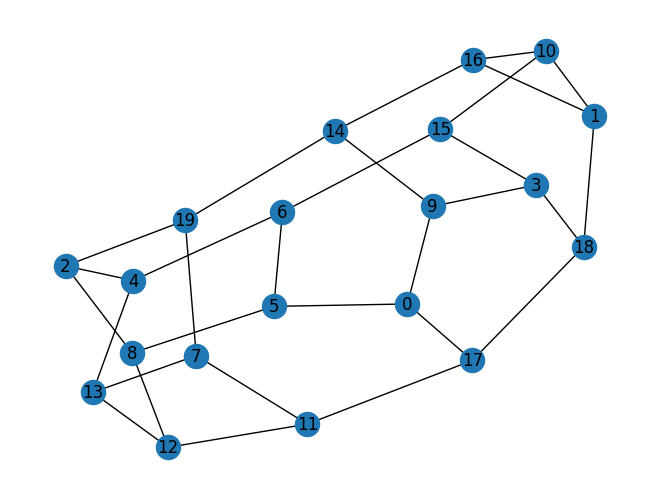

In [3]:
num_nodes = 20
G = nx.random_regular_graph(3, num_nodes)
nx.draw(G, with_labels=True)

In [4]:
instance_data = {'E': [list(edge) for edge in G.edges], 'N': num_nodes}

### Transpile to QRAO Hamiltonian

In [8]:
compiled_instance = jmt.core.compile_model(problem, instance_data)

qrac_builder = jtq.qrao.transpile_to_qrac31_hamiltonian(compiled_instance, normalize=False)

qrac_hamiltonian, offset, encoding_cache = qrac_builder.get_hamiltonian()

In [9]:
print(f"compression ration : {len(encoding_cache.color_group) / num_nodes}")

compression ration : 0.4


In [10]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from scipy.optimize import minimize

In [12]:
num_qubit = len(encoding_cache.color_group)
ansatz = RealAmplitudes(num_qubit, reps=1)

def cost_func(parameters, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=parameters).result().values[0]
    return cost

In [13]:
initial_params = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)
estimator = Estimator()
optimization_history = []
qrac_result = minimize(cost_func, initial_params, args=(ansatz, qrac_hamiltonian, estimator), method='BFGS',callback = lambda x:optimization_history.append(cost_func(x,ansatz, qrac_hamiltonian, estimator)))

厳密解も計算する。

In [24]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver
from jijtranspiler_qiskit.qaoa import to_ising_operator_from_qubo

In [25]:
ising_hamiltonian,ising_const = to_ising_operator_from_qubo(qubo,num_nodes)
eigen_solver = NumPyEigensolver()
result = eigen_solver.compute_eigenvalues(ising_hamiltonian)
ising_optimal = -(np.array(result.eigenvalues) + ising_const)[0].real

In [26]:
eigen_solver = NumPyEigensolver()
result = eigen_solver.compute_eigenvalues(qrac_hamiltonian)
qrac_optimal = -(result.eigenvalues + qrac_const )[0].real

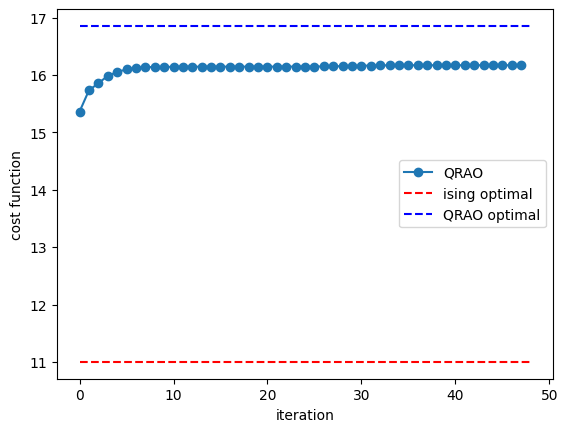

In [28]:
plt.plot(-(np.array(optimization_history) + qrac_const),"o-", label='QRAO')
plt.plot([0, len(optimization_history)],[ising_optimal ,ising_optimal ], "red", linestyle='dashed',label = "ising optimal")
plt.plot([0, len(optimization_history)],[qrac_optimal , qrac_optimal], "blue", linestyle='dashed',label = "QRAO optimal")
plt.xlabel('iteration')
plt.ylabel('cost function')
plt.legend()

In [11]:
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

from jijtranspiler_qiskit.qrao.qrao31 import create_pauli_term

In [24]:
def pauli_rounding(ansatz,qrac_result, encoding_cache):
    encoded_op = encoding_cache.encoding
    n_qubit = len(encoding_cache.color_group)
    variable_ops = [jtq.qrao.qrao31.create_pauli_term([encoded_op[idx][1]], [encoded_op[idx][0]], n_qubit) for idx in encoded_op.keys()]
    
    num_variables = len(variable_ops)
    estimator = Estimator()
    estimator_result = estimator.run([ansatz] * num_variables, variable_ops, parameter_values=[qrac_result.x] * num_variables)
    
    rng = np.random.default_rng()
    def sign(val) -> int:
        return 1 if (val > 0) else 0
    rounded_vars = [sign(e) if not np.isclose(0, e) else rng.choice([0,1]) for e in estimator_result.result().values]
    return rounded_vars

In [25]:
rounding_result = pauli_rounding(ansatz,qrac_result, encoding_cache)

In [27]:
sampleset = qrac_builder.decode_from_binary_values([rounding_result])

In [28]:
sampleset

SampleSet(record=Record(solution={'x': [(([6, 12, 14, 13, 4, 7, 2, 0, 3, 10, 1, 11, 17, 8, 5, 18, 19, 9, 16, 15],), [1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, 1], (20,))]}, num_occurrences=[[1]]), evaluation=Evaluation(energy=None, objective=[-20.0], constraint_violations={}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None))

In [19]:
optimization_history = []
estimator = Estimator()
sampler = Sampler()
vqe = VQD(ansatz=ansatz,initial_point=initial_params,fidelity = ComputeUncompute(sampler),estimator=estimator,optimizer=COBYLA())

In [20]:
vqe_result = vqe.compute_eigenvalues(qrac_hamiltonian)

In [21]:
vqe_result.eigenvalues

array([-1.16846674+0.j, -1.15051786+0.j])

In [29]:
encoded_op = color_group_to_qrac_encode(color_group)
n_qubit = len(color_group)
variable_ops = [create_pauli_term([encoded_op[idx][1]], [encoded_op[idx][0]], n_qubit) for idx in coloring.keys()]

In [30]:
vqe_result = vqe.compute_eigenvalues(qrac_hamiltonian,aux_operators=variable_ops)

In [47]:
def sign(val) -> int:
    return 0 if (val > 0) else 1

trace_value = [v[0] for v in vqe_result.aux_operators_evaluated[0]]
rng = np.random.default_rng()
trace_value

[1.7575082662819874e-05,
 -1.2623833530116257e-05,
 -8.445803392416115e-06,
 7.672026455857878e-05,
 1.176428286078432e-05,
 7.751053507587535e-05,
 0.0,
 0.0,
 -8.799255138644806e-05,
 0.0,
 0.00012376562336851443,
 2.5189837581147488e-05,
 -2.5189854232795874e-05,
 0.0,
 -9.381036060931656e-07,
 0.0,
 9.376563954501773e-07,
 0.0,
 0.9997140513614997,
 -0.9997140483452612]

In [50]:
rounded_vars = [
            sign(e) if not np.isclose(0, e) else rng.integers(0,2)
            for e in trace_value
        ]

In [51]:
rounded_vars

[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]

In [56]:
estimator = Estimator()
estimator_result = estimator.run([ansatz] * len(variable_ops), variable_ops, parameter_values=[qrac_result.x]* len(variable_ops))

In [61]:
estimator_result.result().values

array([ 3.26422875e-05, -2.34434761e-05, -1.56873403e-05,  5.13088526e-06,
        2.18436753e-05,  5.18425520e-06,  0.00000000e+00,  0.00000000e+00,
       -5.88401522e-06,  0.00000000e+00, -8.27805504e-06, -1.55379486e-05,
        1.55378771e-05,  0.00000000e+00, -9.73568951e-06,  0.00000000e+00,
        9.73580368e-06,  0.00000000e+00, -5.28679240e-01,  5.28679240e-01])

# Calculate gap size

In [107]:
def maxcut_problem():
    # define variables
    E = jm.Placeholder('E',dim = 2)
    N = jm.Placeholder('N')
    x = jm.Binary('x', shape=N)
    e = jm.Element('e', E).set_latex('(i,j)')
    s_i = 1 - 2*x[e[0]]
    s_j = 1 - 2*x[e[1]]
    s_i.set_latex('s_i') 
    s_j.set_latex('s_j') 
    
    # set problem
    problem = jm.Problem('MAXCUT')
    problem += -1/2 * jm.Sum(e,1 - s_i*s_j)
    return problem

In [173]:
def calculate_qrac_optimal(qubo):
    coloring, color_group = greedy_graph_coloring(qubo,3)
    qrac_hamiltonian, qrac_const = qrac31_encode(qubo,color_group)
    eigen_solver = NumPyEigensolver()
    result = eigen_solver.compute_eigenvalues(qrac_hamiltonian)
    return -(result.eigenvalues + qrac_const )[0].real

def calculate_ising_optimal(qubo):
    num_qubit = np.max(np.array(list((qubo.keys())))) + 1
    ising_hamiltonian,ising_const = to_ising_operator_from_qubo(qubo,num_qubit)
    eigen_solver = NumPyEigensolver()
    result = eigen_solver.compute_eigenvalues(ising_hamiltonian)
    return -(np.array(result.eigenvalues) + ising_const)[0].real

def calculate_gap_size(problem,instance_data,multipliers={}):
    compiled_model = jmt.core.compile_model(problem,instance_data)
    pubo_builder = jmt.core.pubo.transpile_to_pubo(compiled_model=compiled_model,normalize=False)
    qubo,const = pubo_builder.get_qubo_dict(multipliers=multipliers)
    qrao_optimal = calculate_qrac_optimal(qubo)
    ising_optimal = calculate_ising_optimal(qubo)
    return qrao_optimal - ising_optimal, qrao_optimal, ising_optimal


In [174]:
problem = maxcut_problem()
problem

/tmp/ipykernel_49177/1490413976.py:3: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E',dim = 2)
/tmp/ipykernel_49177/1490413976.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=N)
/tmp/ipykernel_49177/1490413976.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E).set_latex('(i,j)')
/tmp/ipykernel_49177/1490413976.py:14: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  problem += -1/2 * jm.Sum(e,1 - s_i*s_j)


In [175]:
bound_sizes = []
qrao_optimals = []
ising_optimals = []
for num_nodes in range(4,22,2):
    G = nx.random_regular_graph(3, num_nodes)
    instance_data = {'E': [list(edge) for edge in G.edges], 'N': num_nodes}
    gap_size,qrao_optimal,ising_optimal =  calculate_gap_size(problem,instance_data)
    bound_sizes.append(gap_size)
    qrao_optimals.append(qrao_optimal)
    ising_optimals.append(ising_optimal)

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.


Text(0.5, 0, 'number of nodes')

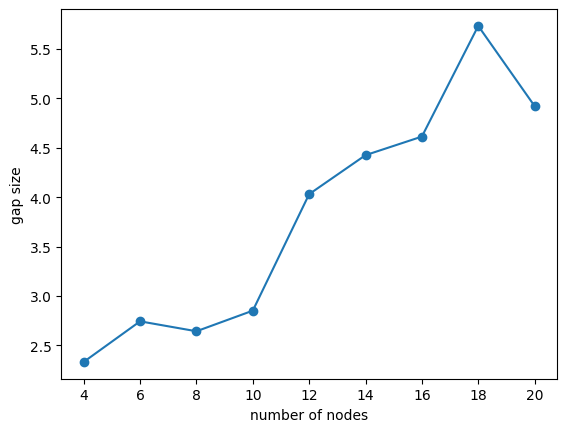

In [168]:
plt.plot(range(4,22,2),bound_sizes,"o-")
plt.ylabel("gap size")
plt.xlabel("number of nodes")

Text(0.5, 0, 'number of nodes')

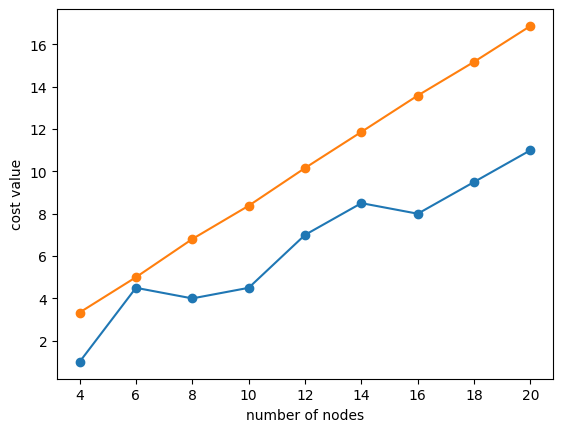

In [178]:
plt.plot(range(4,22,2),ising_optimals,"o-",label = "Ising")
plt.plot(range(4,22,2),qrao_optimals,"o-",label = "QRAO")
plt.ylabel("cost value")
plt.xlabel("number of nodes")

次に、制約条件のある問題であるgraph partitionについて見てみる。

In [180]:
def graph_partition():
    # define variables
    V = jm.Placeholder('V')
    E = jm.Placeholder('E', dim=2)
    x = jm.Binary('x', shape=(V))
    u = jm.Element('u', V)
    e = jm.Element('e', E)# set problem
    problem = jm.Problem('Graph Partitioning')
    # set constraint: the vertices must be partitioined into two equal-sized sets
    const = jm.Sum(u, x[u])
    problem += jm.Constraint('constraint', const==V/2)
    # set objective function: minimize the number of edges crossing the partition
    A_1 = x[e[0]]*(1-x[e[1]])
    A_2 = (1-x[e[0]])*x[e[1]]
    problem += jm.Sum(e, (A_1 + A_2))
    return problem

In [181]:
problem = graph_partition()
problem

/tmp/ipykernel_49177/2149500668.py:4: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E', dim=2)
/tmp/ipykernel_49177/2149500668.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=(V))
/tmp/ipykernel_49177/2149500668.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  u = jm.Element('u', V)
/tmp/ipykernel_49177/2149500668.py:7: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E)# set problem
/tmp/ipykernel_49177/2149500668.py:10: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  const = jm.Sum(

In [192]:
results = {}
for penalty_value in [1,5,10]:
    bound_sizes = []
    qrao_optimals = []
    ising_optimals = []
    for num_nodes in range(4,18,2):
        G = nx.gnp_random_graph(num_nodes, 0.4)
        instance_data = {'E': [list(edge) for edge in G.edges], 'V': num_nodes}
        gap_size,qrao_optimal,ising_optimal =  calculate_gap_size(problem,instance_data,multipliers={'constraint':penalty_value})
        bound_sizes.append(gap_size)
        qrao_optimals.append(qrao_optimal)
        ising_optimals.append(ising_optimal)
        results[penalty_value] = (bound_sizes,qrao_optimals,ising_optimals)
        

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_penalty` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_multiplier` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `auto_qubo` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `label` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `name` instead.
<frozen jijmodeling.tra

Gap幅は大きくペナルティ係数の値に依存していることがわかる。

In [193]:
print(results)

{1: ([1.5, 1.166666666666666, 4.0, 8.833333333333334, 13.166666666666668, 18.0, 29.666666666666664], [3.0, 4.666666666666666, 7.0, 14.333333333333334, 19.666666666666668, 30.0, 40.666666666666664], [1.5, 3.5, 3.0, 5.5, 6.5, 12.0, 11.0]), 5: ([10.833333333333332, 27.833333333333336, 56.0, 92.66666666666667, 135.33333333333334, 191.0, 259.0], [16.333333333333332, 36.333333333333336, 68.0, 106.66666666666667, 154.33333333333334, 215.0, 286.0], [5.5, 8.5, 12.0, 14.0, 19.0, 24.0, 27.0]), 10: ([22.5, 61.33333333333333, 120.0, 195.0, 298.3333333333333, 409.5, 544.6666666666666], [33.0, 77.33333333333333, 141.0, 222.0, 332.3333333333333, 453.0, 594.6666666666666], [10.5, 16.0, 21.0, 27.0, 34.0, 43.5, 50.0])}


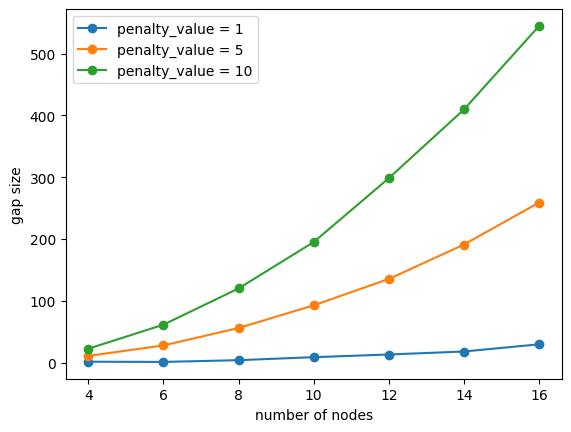

In [194]:
for key,value in results.items():
    plt.plot(range(4,18,2),value[0],"o-",label = f"penalty_value = {key}")
plt.ylabel("gap size")
plt.xlabel("number of nodes")
plt.legend()

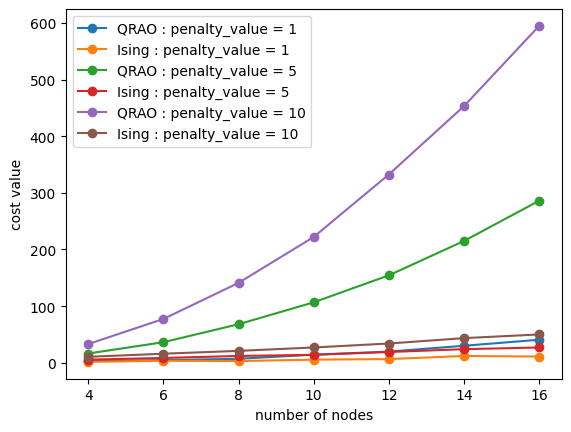

In [197]:
for key,value in results.items():
    plt.plot(range(4,18,2),value[1],"o-",label = f"QRAO : penalty_value = {key}")
    plt.plot(range(4,18,2),value[2],"o-",label = f"Ising : penalty_value = {key}")
plt.ylabel("cost value")
plt.xlabel("number of nodes")
plt.legend()